In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import glob
import os.path
import re
import pandas as pd

import seaborn as sns
from latexify import latexify, format_axes

/home/fl350/.pyenv/versions/2.7.11/envs/jupyter/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Theanets RNN search

LSTM and GRU yield most promising performance, but require regularization

In [6]:
theanets_data = '/home/fl350/data/theanets_cv/'

In [7]:
import pickle
losses_t = pickle.load(open(theanets_data + 'losses_t.pkl', 'rb'))
losses_v = pickle.load(open(theanets_data + 'losses_v.pkl', 'rb'))

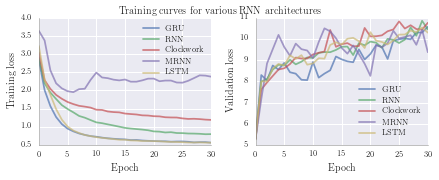

In [26]:
latexify(fig_height=2.5, columns=2)

fig, (ax1,ax2) = plt.subplots(1,2)

for i, form in enumerate(losses_t.keys()):
    if form in ['scrn']:
        continue
    if form == 'clockwork':
        lab = 'Clockwork'
    else:
        lab = form.upper()
    ax1.plot(losses_t[form], label=lab, alpha=0.7)
    ax2.plot(losses_v[form], label=lab, alpha=0.7)

for ax in [ax1, ax2]:
    ax.set_xlabel('Epoch')
    ax.legend(loc='best')
    if ax == ax1:
        ax1.set_ylabel('Training loss')
    else:
        ax2.set_ylabel('Validation loss')

format_axes(ax1)
format_axes(ax2)
fig.suptitle('Training curves for various RNN architectures')
fig.tight_layout()
fig.savefig('theanets-architecture.pgf', bbox_inches='tight', dpi=300)
fig.show()

# `torch-rnn` grid search

In [20]:
torch_logs = '/home/fl350/data/torch_logs'

confs = dict()
train = dict()
val = dict()
for log_path in glob.glob(os.path.join(torch_logs, '*.log')):
    conf = dict()
    for param in re.split(r'[,\s]*', os.path.basename(log_path)[:-4]):
        k, v = param.split('=')
        conf[k] = float(v)
        
    train_list = []
    val_list = []
    with open(log_path, 'r') as log:
        prev_epoch = None
        for line in log:
            if line[:5] == 'Epoch':
                values = re.split(r'[,\s]*', line)
                train_list.append({
                        'epoch': float(values[1]),
                        'loss': float(values[-2])
                    })
                prev_epoch = train_list[-1]['epoch']
            if line[:3] == 'val':
                val_list.append({
                        'epoch': prev_epoch,
                        'loss': float(line.split()[-1])
                    })
    train[log_path] = pd.DataFrame(train_list, columns=['epoch', 'loss'])
    val[log_path] = pd.DataFrame(val_list, columns=['epoch', 'loss'])
    confs[log_path] = conf
confs = pd.DataFrame(confs).T

## Enumerate all performance results

In [21]:
config_perfs = (confs
                .loc[[log_path for log_path in confs.index if len(val[log_path]['loss']) != 0]]
                .assign(val_metric=lambda df: map(lambda x: val[x]['loss'].iloc[-1], df.index),
                        train_metric=lambda df: map(lambda x: train[x]['loss'].iloc[-10:].mean(), df.index))
                .sort_values(['val_metric', 'train_metric']))
with open('torch-rnn-config-perfs.tex', 'wb') as f:
    f.write(
        config_perfs[[
                'num_layers',
                'rnn_size',
                'seq_length',
                'wordvec',
                'train_metric',
                'val_metric']].to_latex(index=False,longtable=True))

# Dropout improves generalization

/home/fl350/.pyenv/versions/2.7.11/envs/jupyter/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/home/fl350/.pyenv/versions/2.7.11/envs/jupyter/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/fl350/.pyenv/versions/2.7.11/envs/jupyter/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


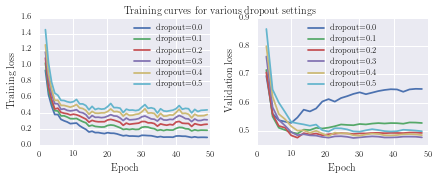

In [27]:
confs_subset = confs[
    confs['wordvec'] == 32][
    confs['seq_length'] == 128][
    confs['rnn_size'] == 256][
    confs['num_layers'] == 3]

latexify(fig_height=2.5, columns=2)
fig, (ax1,ax2) = plt.subplots(1,2)

for log_path in confs_subset.index:
    lab = 'dropout={}'.format(*(confs.loc[log_path][['dropout']]))
    
    train_subset = train[log_path][train[log_path]['epoch'] <= 50]
    ax1.plot(train_subset['epoch'], train_subset['loss'], label=lab)

    val_subset = val[log_path][val[log_path]['epoch'] <= 50]
    ax2.plot(val_subset['epoch'], val_subset['loss'], label=lab)

for ax in [ax1, ax2]:
    ax.set_xlabel('Epoch')
    ax.legend(loc='best')
    if ax == ax1:
        ax1.set_ylabel('Training loss')
    else:
        ax2.set_ylabel('Validation loss')
        
fig.suptitle('Training curves for various dropout settings')
fig.tight_layout()
fig.savefig('torch-rnn-dropout.pgf', bbox_inches='tight', dpi=300)
fig.show()

## Sensitivity to network parameters `num_layers` and `rnn_size`

 * Larger `rnn_size` leads to higher capacity and lower training loss
     * Presents as overfitting on validation, where the lowest capacity model `rnn_size` appears to be improving in generalization while others are flat/increasing
 * Training curves about the same wrt `num_layers`, validation curves have interesting story
     * Depth matters: small `64` and `128` hidden unit RNNs saw improvements up to `0.09`
     * Expressivity gained from depth furthers overfitting: `256` hidden unit RNN has some of the best validation performance at depth `1` but is the worst generalizing model for depths `2` and `3` even though training loss is low
 * `rnn_size=128` undisputably best generalizing, optimized at `num_layers=2`: will continue with these settings

/home/fl350/.pyenv/versions/2.7.11/envs/jupyter/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/home/fl350/.pyenv/versions/2.7.11/envs/jupyter/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


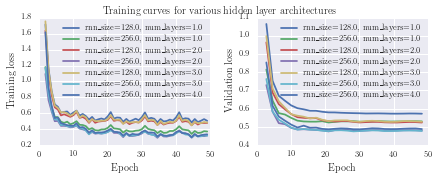

In [30]:
confs_subset = confs[
    confs['wordvec'] == 32][
    confs['seq_length'] == 128][
    confs['dropout'] == 0.3][confs['rnn_size'] <= 256.0]

latexify(fig_height=2.5, columns=2)
fig, (ax1,ax2) = plt.subplots(1,2)

for log_path in confs_subset.index:
    lab = 'rnn\_size={0}, num\_layers={1}'.format(*(confs.loc[log_path][['rnn_size', 'num_layers']]))
    
    train_subset = train[log_path][train[log_path]['epoch'] <= 50]
    ax1.plot(train_subset['epoch'], train_subset['loss'], label=lab)

    val_subset = val[log_path][val[log_path]['epoch'] <= 50]
    ax2.plot(val_subset['epoch'], val_subset['loss'], label=lab)
    
for ax in [ax1, ax2]:
    ax.set_xlabel('Epoch')
    ax.legend(loc='best')
    if ax == ax1:
        ax1.set_ylabel('Training loss')
    else:
        ax2.set_ylabel('Validation loss')
    
fig.suptitle('Training curves for various hidden layer architectures')
fig.tight_layout()
fig.savefig('torch-rnn-network-params.pgf', bbox_inches='tight', dpi=300)
fig.show()

/home/fl350/.pyenv/versions/2.7.11/envs/jupyter/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/home/fl350/.pyenv/versions/2.7.11/envs/jupyter/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


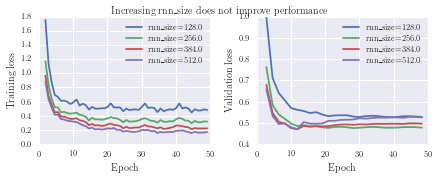

In [36]:
confs_subset = confs[
    confs['wordvec'] == 32][
    confs['seq_length'] == 128][
    confs['dropout'] == 0.3][confs['num_layers'] == 3]

latexify(fig_height=2.5, columns=2)
fig, (ax1,ax2) = plt.subplots(1,2)

for log_path in confs_subset.index:
    lab = 'rnn\_size={0}'.format(*(confs.loc[log_path][['rnn_size']]))

    train_subset = train[log_path][train[log_path]['epoch'] <= 50]
    ax1.plot(train_subset['epoch'], train_subset['loss'], label=lab)

    val_subset = val[log_path][val[log_path]['epoch'] <= 50]
    ax2.plot(val_subset['epoch'], val_subset['loss'], label=lab)

for ax in [ax1, ax2]:
    ax.set_xlabel('Epoch')
    ax.legend(loc='best')
    if ax == ax1:
        ax1.set_ylabel('Training loss')
    else:
        ax2.set_ylabel('Validation loss')
    
fig.suptitle('Increasing rnn\_size does not improve performance')
fig.tight_layout()
fig.savefig('torch-rnn-network-params-rnn-size.pgf', bbox_inches='tight', dpi=300)
fig.show()

/home/fl350/.pyenv/versions/2.7.11/envs/jupyter/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/home/fl350/.pyenv/versions/2.7.11/envs/jupyter/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/fl350/.pyenv/versions/2.7.11/envs/jupyter/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


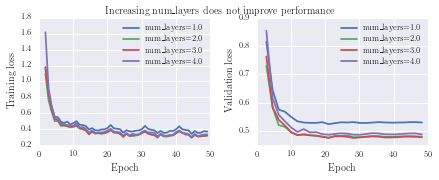

In [35]:
confs_subset = confs[
    confs['wordvec'] == 32][
    confs['seq_length'] == 128][
    confs['dropout'] == 0.3][
    confs['rnn_size'] == 256]

latexify(fig_height=2.5, columns=2)
fig, (ax1,ax2) = plt.subplots(1,2)

for log_path in confs_subset.index:
    lab = 'num\_layers={0}'.format(*(confs.loc[log_path][['num_layers']]))

    train_subset = train[log_path][train[log_path]['epoch'] <= 50]
    ax1.plot(train_subset['epoch'], train_subset['loss'], label=lab)

    val_subset = val[log_path][val[log_path]['epoch'] <= 50]
    ax2.plot(val_subset['epoch'], val_subset['loss'], label=lab)

for ax in [ax1, ax2]:
    ax.set_xlabel('Epoch')
    ax.legend(loc='best')
    if ax == ax1:
        ax1.set_ylabel('Training loss')
    else:
        ax2.set_ylabel('Validation loss')
    
fig.suptitle('Increasing num\_layers does not improve performance')
fig.tight_layout()
fig.savefig('torch-rnn-network-params-num-layers.pgf', bbox_inches='tight', dpi=300)
fig.show()

## Sensitivity to network input parameters `seq_length` and `wordvec`

* Training losses are about the same across all `wordvec`s
* Validation losses suggest that increasing `seq_length` important for good performance (**TODO**: investigate further)
* `wordvec=128` overfits for all cases, the other two depend on `seq_length` and vary an order of magnitude smaller than the performance gains from increasing `seq_length`

/home/fl350/.pyenv/versions/2.7.11/envs/jupyter/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/home/fl350/.pyenv/versions/2.7.11/envs/jupyter/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/fl350/.pyenv/versions/2.7.11/envs/jupyter/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/fl350/.pyenv/versions/2.7.11/envs/jupyter/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


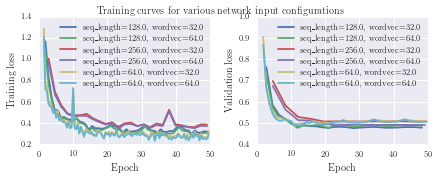

In [38]:
confs_subset = confs[
    confs['num_layers'] == 3][
    confs['rnn_size'] == 256][
    confs['dropout'] == 0.3][
    confs['seq_length'] <= 256][
    confs['wordvec'] >= 32]

latexify(fig_height=2.5, columns=2)
fig, (ax1,ax2) = plt.subplots(1,2)

for log_path in confs_subset.index:
    lab = 'seq\_length={0}, wordvec={1}'.format(*(confs.loc[log_path][['seq_length', 'wordvec']]))

    train_subset = train[log_path][train[log_path]['epoch'] <= 50]
    ax1.plot(train_subset['epoch'], train_subset['loss'], label=lab)

    val_subset = val[log_path][val[log_path]['epoch'] <= 50]
    ax2.plot(val_subset['epoch'], val_subset['loss'], label=lab)


for ax in [ax1, ax2]:
    ax.set_xlabel('Epoch')
    ax.legend(loc='best')
    if ax == ax1:
        ax1.set_ylabel('Training loss')
    else:
        ax2.set_ylabel('Validation loss')
    
fig.suptitle('Training curves for various network input configurations')
fig.tight_layout()
fig.savefig('torch-rnn-input-params.pgf', bbox_inches='tight', dpi=300)
fig.show()

/home/fl350/.pyenv/versions/2.7.11/envs/jupyter/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/home/fl350/.pyenv/versions/2.7.11/envs/jupyter/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/fl350/.pyenv/versions/2.7.11/envs/jupyter/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/fl350/.pyenv/versions/2.7.11/envs/jupyter/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


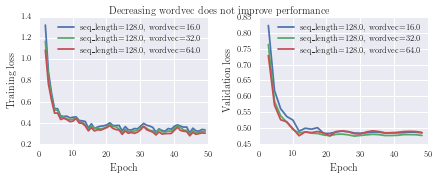

In [39]:
confs_subset = confs[
    confs['num_layers'] == 3][
    confs['rnn_size'] == 256][
    confs['dropout'] == 0.3][
    confs['seq_length'] == 128][
    confs['wordvec'] <= 64]

latexify(fig_height=2.5, columns=2)
fig, (ax1,ax2) = plt.subplots(1,2)

for log_path in confs_subset.index:
    lab = 'seq\_length={0}, wordvec={1}'.format(*(confs.loc[log_path][['seq_length', 'wordvec']]))

    train_subset = train[log_path][train[log_path]['epoch'] <= 50]
    ax1.plot(train_subset['epoch'], train_subset['loss'], label=lab)
    
    val_subset = val[log_path][val[log_path]['epoch'] <= 50]
    ax2.plot(val_subset['epoch'], val_subset['loss'], label=lab)


for ax in [ax1, ax2]:
    ax.set_xlabel('Epoch')
    ax.legend(loc='best')
    if ax == ax1:
        ax1.set_ylabel('Training loss')
    else:
        ax2.set_ylabel('Validation loss')
    
fig.suptitle('Decreasing wordvec does not improve performance')
fig.tight_layout()
fig.savefig('torch-rnn-input-params-wordvec.pgf', bbox_inches='tight', dpi=300)
fig.show()

# Long training trace for best model

/home/fl350/.pyenv/versions/2.7.11/envs/jupyter/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/home/fl350/.pyenv/versions/2.7.11/envs/jupyter/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/fl350/.pyenv/versions/2.7.11/envs/jupyter/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/fl350/.pyenv/versions/2.7.11/envs/jupyter/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


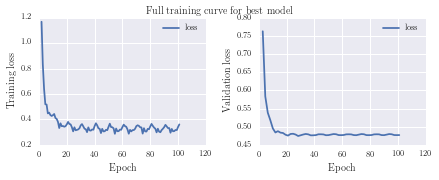

In [40]:
confs_subset = confs[
    confs['num_layers'] == 3][
    confs['rnn_size'] == 256][
    confs['dropout'] == 0.3][
    confs['seq_length'] == 128][
    confs['wordvec'] == 32]

latexify(fig_height=2.5, columns=2)
fig, (ax1,ax2) = plt.subplots(1,2)

for log_path in confs_subset.index:
    ax1.plot(train[log_path]['epoch'], train[log_path]['loss'])
    ax2.plot(val[log_path]['epoch'], val[log_path]['loss'])

for ax in [ax1, ax2]:
    ax.set_xlabel('Epoch')
    ax.legend(loc='best')
    if ax == ax1:
        ax1.set_ylabel('Training loss')
    else:
        ax2.set_ylabel('Validation loss')
    
fig.suptitle('Full training curve for best model')
fig.tight_layout()
fig.savefig('torch-rnn-best-model-trace.pgf', bbox_inches='tight', dpi=300)
fig.show()